# Image recognition with Python, OpenCV, OpenAI CLIP model and PostgreSQL `pgvector`

This repository contains the working code for the example in the [resource](https://aiven.io/developer/find-faces-with-pgvector)

The below is the overall flow:

![Overall flow](https://github.com/Aiven-Labs/pgvector-image-recognition/blob/main/entire_flow.jpg?raw=1)

## Installation of dependencies

In [ ]:
!pip install opencv-python
!pip install imgbeddings
!pip install psycopg2-binary

## Necessary Imports

In [8]:
import cv2
import numpy as np
from imgbeddings import imgbeddings
from PIL import Image
import psycopg2
import os
from IPython.display import Image, display

##  Face recognition

Detect the faces from the [test-image](test-image.png) picture and store them under the `stored-faces` folder

In [ ]:
# loading the haar case algorithm file into alg variable
alg = "/content/drive/MyDrive/haarcascade_frontalface_default.xml"
# passing the algorithm to OpenCV
haar_cascade = cv2.CascadeClassifier(alg)
# loading the image path into file_name variable
file_name = "/content/drive/MyDrive/James_Bond_Daniel_Craig_442621.jpg"
# reading the image
img = cv2.imread(file_name, 0)
# creating a black and white version of the image
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# detecting the faces
faces = haar_cascade.detectMultiScale(
    gray_img, scaleFactor=1.05, minNeighbors=2, minSize=(100, 100)
)

i = 0
# for each face detected
for x, y, w, h in faces:
    # crop the image to select only the face
    cropped_image = img[y : y + h, x : x + w]
    # loading the target image path into target_file_name variable  - replace <INSERT YOUR TARGET IMAGE NAME HERE> with the path to your target image
    target_file_name = 'stored-faces/' + str(i) + '.jpg'
    cv2.imwrite(
        target_file_name,
        cropped_image,
    )
    i = i + 1;

## Embeddings Calculation

Calculate embeddings from the faces and pushing to PostgreSQL

In [6]:
# connecting to the database - replace the SERVICE URI with the service URI
conn = psycopg2.connect("replace the SERVICE URI with the service URI")

for filename in os.listdir("stored-faces"):
    # opening the image
    img = Image.open("stored-faces/" + filename)
    # loading the `imgbeddings`
    ibed = imgbeddings()
    # calculating the embeddings
    embedding = ibed.to_embeddings(img)
    cur = conn.cursor()
    cur.execute("INSERT INTO pictures values (%s,%s)", (filename, embedding[0].tolist()))
    print(filename)
conn.commit()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:655: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


patch32_v1.onnx:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:143: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


0.jpg


## Calculate embeddings on a new picture

Find the face and calculate the embeddings on the picture `solo-image.png` used for research

In [7]:
# loading the face image path into file_name variable
file_name = "/content/drive/MyDrive/158034-frederika.jpg"
# opening the image
img = Image.open(file_name)
# loading the `imgbeddings`
ibed = imgbeddings()
# calculating the embeddings
embedding = ibed.to_embeddings(img)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:655: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


##Find similar images by querying the Postgresql database using pgvector

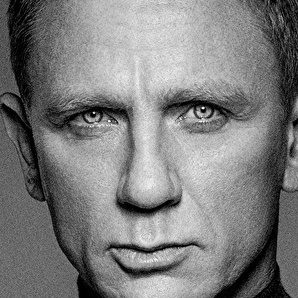

In [9]:
cur = conn.cursor()
string_representation = "["+ ",".join(str(x) for x in embedding[0].tolist()) +"]"
cur.execute("SELECT * FROM pictures ORDER BY embedding <-> %s LIMIT 1;", (string_representation,))
rows = cur.fetchall()
for row in rows:
    display(Image(filename="stored-faces/"+row[0]))
cur.close()